In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math

In [2]:
from quant_functions import anal_funcs, data_funcs

In [3]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from itertools import product

In [4]:
import yfinance as yf
## FRED 정보 수집
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [5]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [6]:
from scipy.signal import find_peaks
import scipy.fft

## Func

In [7]:
## 주요 이평선 ## 피보나치
def get_signals(df, target):
    dataset = df[[target]].copy()
    dataset['M20'] = dataset[target].rolling(20).mean()
    dataset['M60'] = dataset[target].rolling(60).mean()
    dataset['M120'] = dataset[target].rolling(120).mean()
    dataset['M200'] = dataset[target].rolling(200).mean()
    dataset['M500'] = dataset[target].rolling(500).mean()

    ## dataset['D10'] = dataset[target].max() * (1-.1)
    ## dataset['D20'] = dataset[target].max() * (1-.2)
    ## dataset['D30'] = dataset[target].max() * (1-.3)
    dataset['F-4'] = dataset[target].max() * (1-0.6180339887498949)
    dataset['F-3'] = dataset[target].max() * (1-0.38196601125010515)
    dataset['F-2'] = dataset[target].max() * (1-0.2360679774997897)
    dataset['F-1'] = dataset[target].max() * (1-0.14589803375031546)
    
    return dataset

## Data

In [8]:
## etfs
## df = data_funcs.get_merged_df('TQQQ', 'UPRO', 'EURL', 'EDC')

In [9]:
df = data_funcs.get_merged_df('^IXIC', '^GSPC', 'GC=F', 'TMF')
DGS20 = fred.get_series('DGS20')
DGS10 = fred.get_series('DGS10')
DGS2 = fred.get_series('DGS2')
DTB3 = fred.get_series('DTB3')
DFF = fred.get_series('DFF')
df = df.fillna(method = 'pad')

[*********************100%%**********************]  4 of 4 completed


In [10]:
rate_df = pd.DataFrame([DFF, DTB3, DGS2, DGS10, DGS20], index=['DFF', 'TB3M', 'GS2Y', 'GS10Y', 'GS20Y']).T.fillna(method='pad').sort_index()

In [11]:
## https://github.com/Boulder-Investment-Technologies/lppls

## Back test

In [12]:
## 분석 대상 지수
ticker = '^IXIC'

In [13]:
dataset = df.copy()

In [14]:
rate_data = rate_df.copy()
rate_data['T10Y3M'] = rate_data['GS10Y'] - rate_data['TB3M']
rate_data = rate_data.fillna(method='pad').dropna(subset=['T10Y3M'])

In [15]:
## 경기침체와 MDD
mdd_df = dataset.copy()
srs = mdd_df[ticker]
def get_hp(srs):
    '''전고점 탐색 함수'''
    return [srs[:i+1].max() for i in range(len(srs))]
mdd_df['hp'] = get_hp(srs)
mdd_df['mdd'] = (mdd_df[ticker] - mdd_df['hp'])/mdd_df['hp']

mdd_df['경기침체'] = '정상'

mdd_df['경기침체']['1948-11-01':'1949-10-28'] = '세계전충격'
mdd_df['경기침체']['1953-07-01':'1954-05-28'] = '한국전충격'
mdd_df['경기침체']['1957-08-01':'1958-04-28'] = '아이젠하워리세션'
mdd_df['경기침체']['1960-04-01':'1961-02-28'] = '연착륙'
mdd_df['경기침체']['1969-12-01':'1970-10-29'] = '달러위기'
mdd_df['경기침체']['1973-11-05':'1975-03-03'] = '1차오일쇼크'
mdd_df['경기침체']['1980-01-02':'1980-07-02'] = '2차오일쇼크'
mdd_df['경기침체']['1981-07-01':'1982-11-03'] = '물가충격'
mdd_df['경기침체']['1990-07-05':'1991-03-01'] = '걸프전'
mdd_df['경기침체']['2001-03-02':'2001-11-02'] = '닷컴버블'
mdd_df['경기침체']['2007-12-04':'2009-06-01'] = '금융위기'
mdd_df['경기침체']['2020-01-31':'2020-04-03'] = '코로나'
## mdd_df['경기침체']['2023-09-01':'2024-03-31'] = 'Now'

### YRR

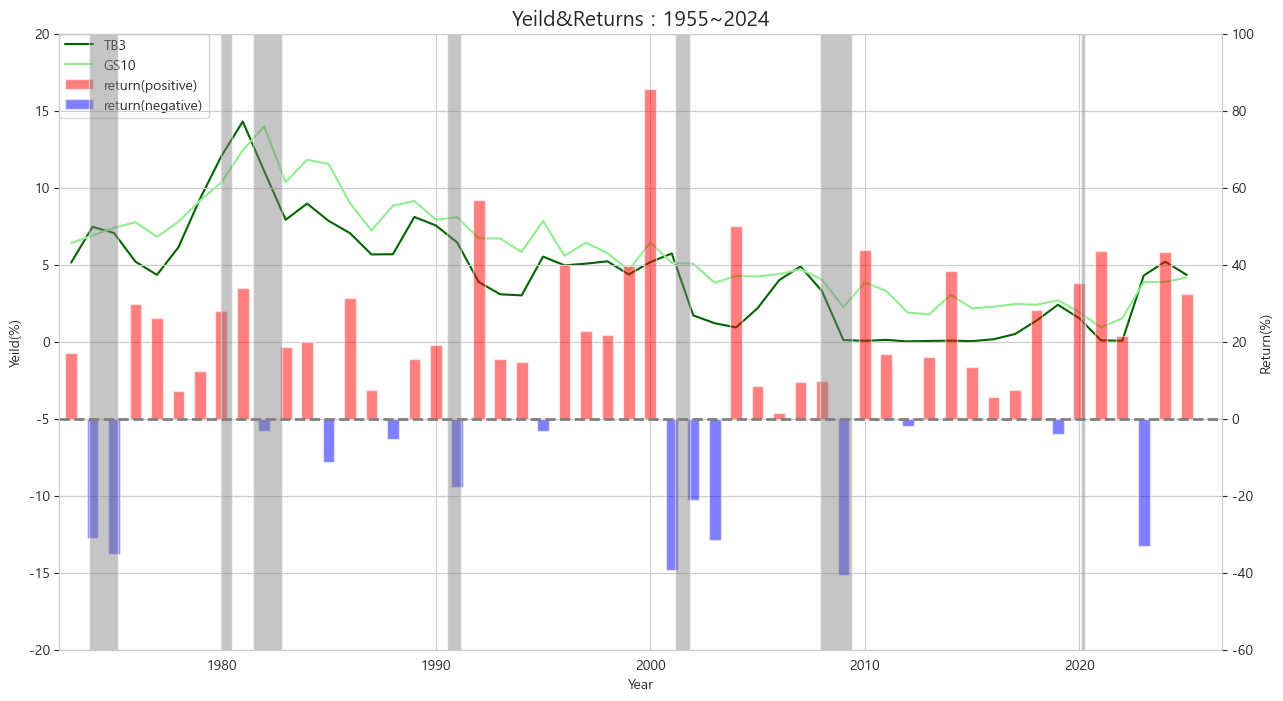

In [16]:
## 시각화
data = dataset.copy()

data[['TB3', 'GS10']] = rate_data[['TB3M', 'GS10Y']].copy()
data = data.fillna(method = 'pad')

data = data.resample('Y').last()

data['return'] = data[ticker].pct_change()
data = data.dropna(subset = ['TB3', 'GS10', 'return'])
data['return'] = data['return'] * 100

fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
line1 = ax1.plot(data.index, data['TB3'],
         color="darkgreen", label="TB3")
line2 = ax1.plot(data.index, data['GS10'],
         color="lightgreen", label="GS10")
performance_plus = data['return'][data['return']>=0]
ax2.bar(performance_plus.index, performance_plus,
        color="red", alpha=0.5, width=200, label="return(positive)")

performance_minus = data['return'][data['return']<0]
ax2.bar(performance_minus.index, performance_minus,
        color="blue", alpha=0.5, width=200, label="return(negative)")
ax2.axhline(0, color='gray', linestyle='--', linewidth=2)

plt.tick_params(labelsize=10)  # font size of tick labels
plt.title("Yeild&Returns : 1955~2024", fontsize=15)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
ax1.set_xlabel("Year")
ax1.set_ylabel("Yeild(%)")
ax1.set_ylim([-20, 20])
ax1.set_xlim([min(data.index) - dt.timedelta(days=200),
              max(data.index) + dt.timedelta(days=600)])

ax2.set_ylabel("Return(%)")
ax2.set_ylim([-60, 100])

## 경기침체
plt.axvspan('1948-11-01', '1949-10-28', facecolor='gray', alpha=0.45)
plt.axvspan('1953-07-01', '1954-05-28', facecolor='gray', alpha=0.45)
plt.axvspan('1957-08-01', '1958-04-28', facecolor='gray', alpha=0.45)
plt.axvspan('1960-04-01', '1961-02-28', facecolor='gray', alpha=0.45)
plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)
## plt.axvspan('2023-09-01', '2024-03-31', facecolor='gray', alpha=0.45)

plt.show()

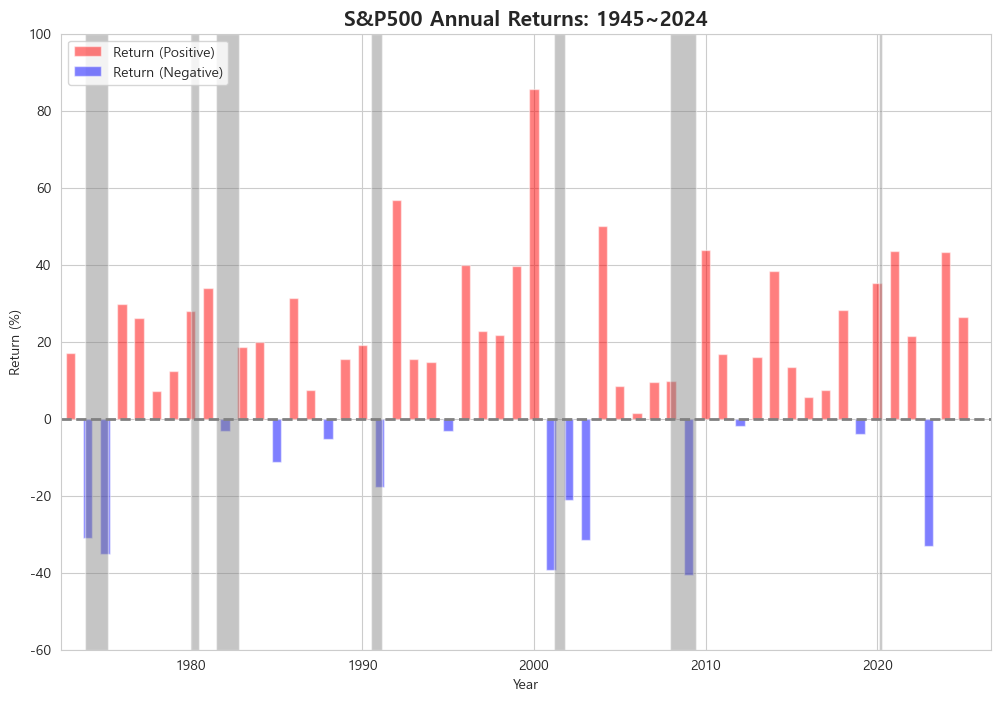

In [42]:
## Return 데이터만 시각화
data = dataset['1945':].copy()

data = data.fillna(method='pad')
data = data.resample('Y').last()
data['return'] = data[ticker].pct_change()
data['return'] = data['return'] * 100
data = data.dropna(subset=['return'])

fig, ax = plt.subplots(figsize=(12, 8))

# Positive Returns
performance_plus = data['return'][data['return'] >= 0]
ax.bar(performance_plus.index, performance_plus, 
       color="red", alpha=0.5, width=200, label="Return (Positive)")

# Negative Returns
performance_minus = data['return'][data['return'] < 0]
ax.bar(performance_minus.index, performance_minus, 
       color="blue", alpha=0.5, width=200, label="Return (Negative)")

# Zero Line
ax.axhline(0, color='gray', linestyle='--', linewidth=2)

# Plot Customization
plt.tick_params(labelsize=10)
plt.title("S&P500 Annual Returns: 1945~2024", fontsize=15, fontweight='bold')
ax.set_xlabel("Year")
ax.set_ylabel("Return (%)")
ax.set_ylim([-60, 100])
ax.set_xlim([min(data.index) - dt.timedelta(days=200), 
             max(data.index) + dt.timedelta(days=600)])

## 경기침체
plt.axvspan('1948-11-01', '1949-10-28', facecolor='gray', alpha=0.45)
plt.axvspan('1953-07-01', '1954-05-28', facecolor='gray', alpha=0.45)
plt.axvspan('1957-08-01', '1958-04-28', facecolor='gray', alpha=0.45)
plt.axvspan('1960-04-01', '1961-02-28', facecolor='gray', alpha=0.45)
plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)
# plt.axvspan('2023-09-01', '2024-03-31', facecolor='gray', alpha=0.45)

# Legend
ax.legend(loc='upper left')

plt.show()


### Oil-shock

In [43]:
df_sig_p1 = get_signals(dataset["1971-06-01":"1977"], ticker)

In [44]:
df_sig_p1[ticker].min()/df_sig_p1[ticker].max() -1

-0.5990207512400275

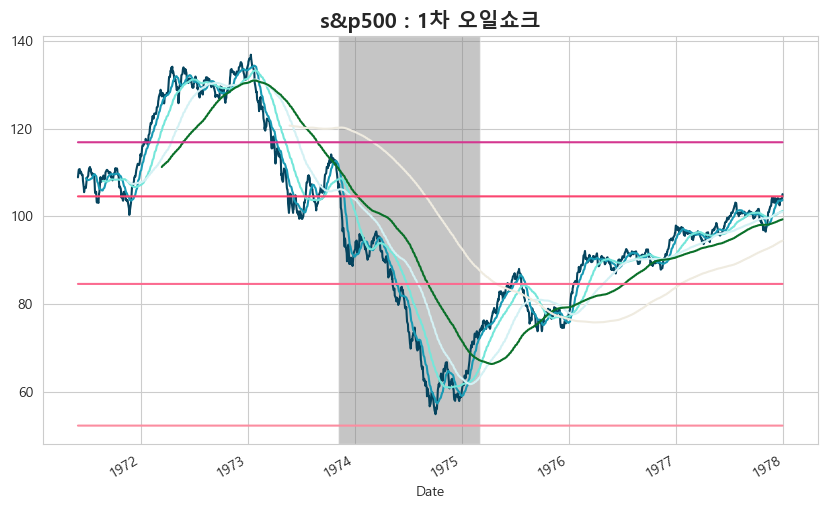

In [45]:
df_sig_p1.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#0A7029',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.title("s&p500 : 1차 오일쇼크", fontsize=15, fontweight='bold')
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
## plt.axvline(x = '1973-11-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

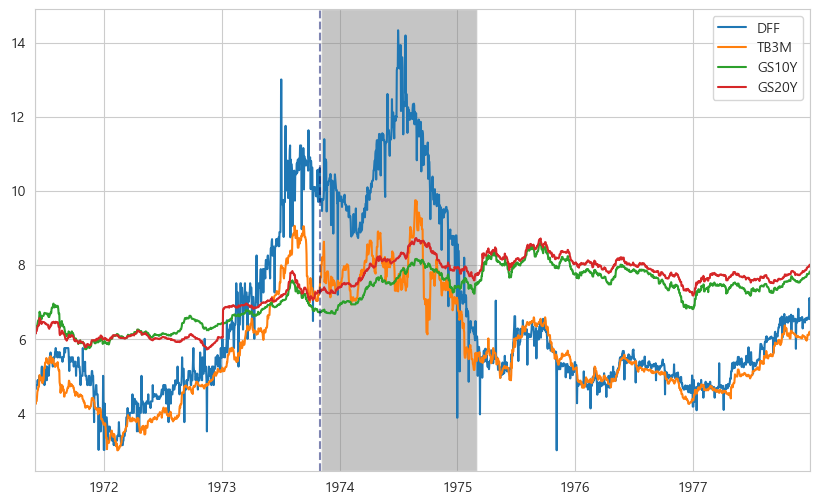

In [46]:
rate_df['1971-06-01':'1977-12-30'][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-11-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

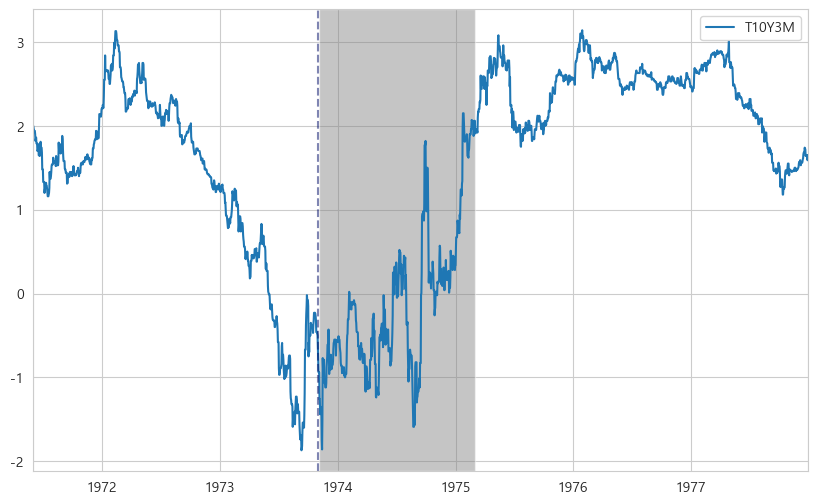

In [47]:
rate_data[['T10Y3M']]['1971-06-01':'1977-12-30'].plot()
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-11-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

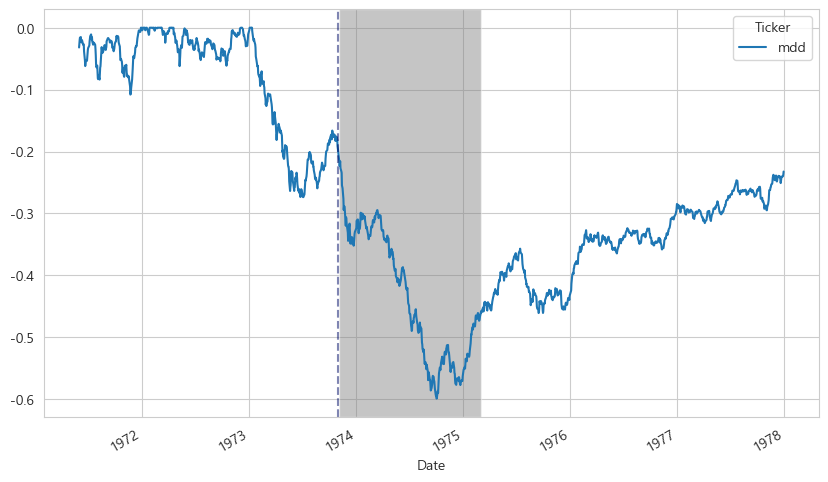

In [48]:
mdd_df[['mdd']]['1971-06-01':'1977-12-30'].plot()
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-11-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

### Dot-com

In [49]:
df_sig_p2 = get_signals(dataset["1999":"2003"], ticker)

In [52]:
df_sig_p2['^IXIC'].min()/df_sig_p2['^IXIC'].max() -1

-0.7793238628593402

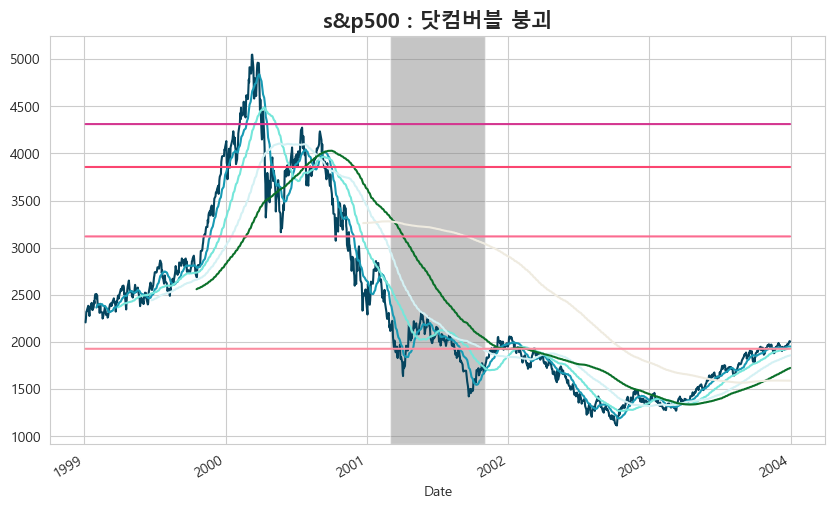

In [50]:
df_sig_p2.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#0A7029',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.title("s&p500 : 닷컴버블 붕괴", fontsize=15, fontweight='bold')
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
# plt.axvline(x = '2000-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

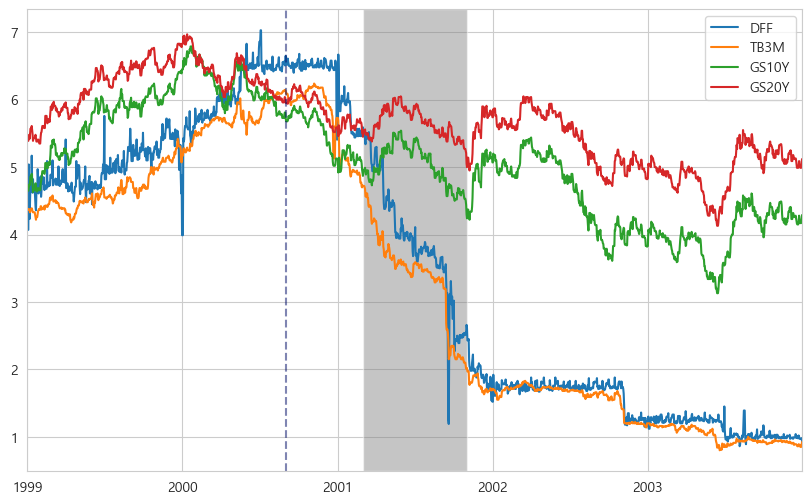

In [55]:
rate_df["1999":"2003"][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

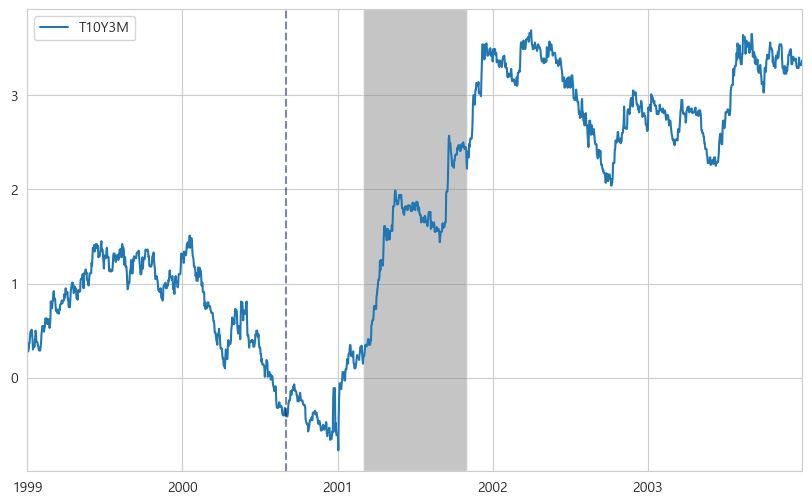

In [56]:
rate_data[['T10Y3M']]["1999":"2003"].plot()
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

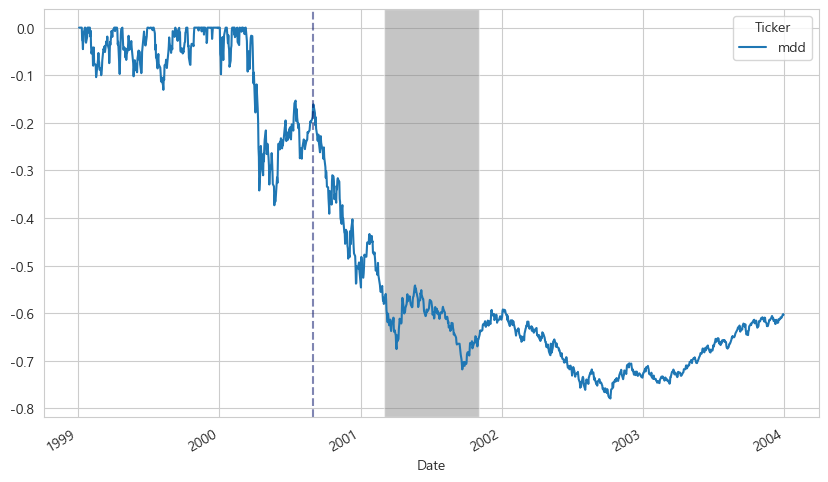

In [57]:
mdd_df[['mdd']]["1999":"2003"].plot()
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

### Sub-prime

In [58]:
df_sig_p3 = get_signals(dataset["2005":"2010"], ticker)

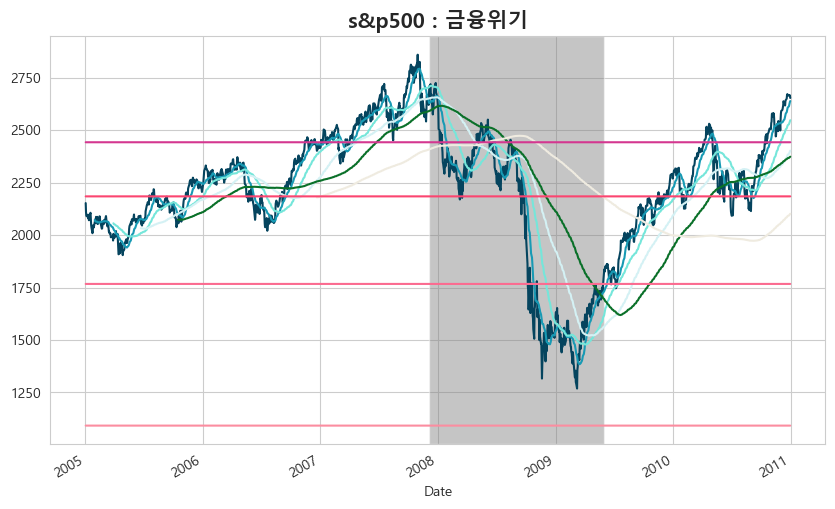

In [59]:
df_sig_p3.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#0A7029',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
plt.title("s&p500 : 금융위기", fontsize=15, fontweight='bold')                   
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
# plt.axvline(x = '2006-07-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

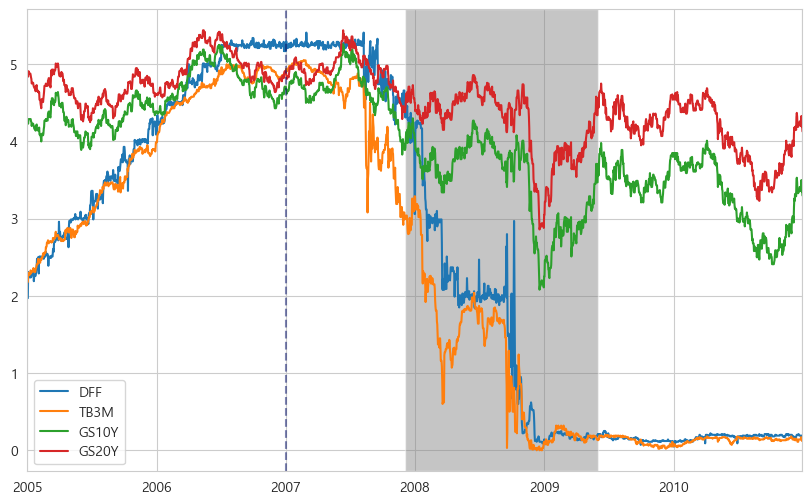

In [82]:
rate_df["2005":"2010"][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvline(x = '2007-01-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

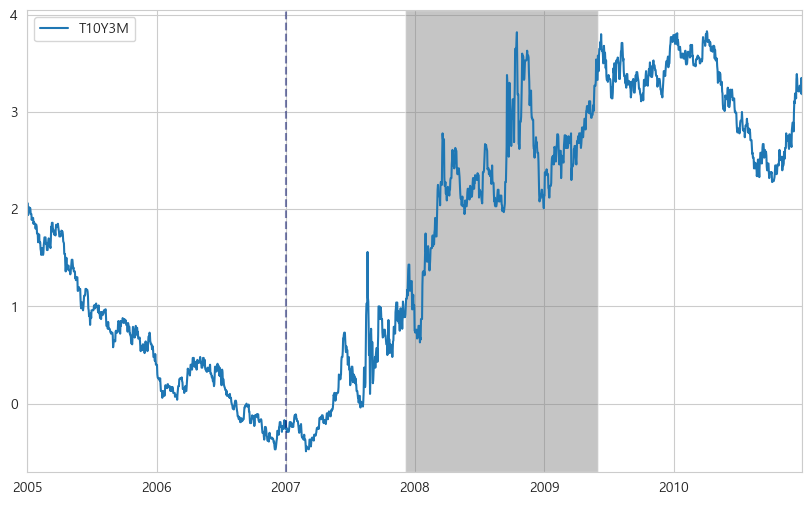

In [83]:
rate_data[['T10Y3M']]["2005":"2010"].plot()
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvline(x = '2007-01-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

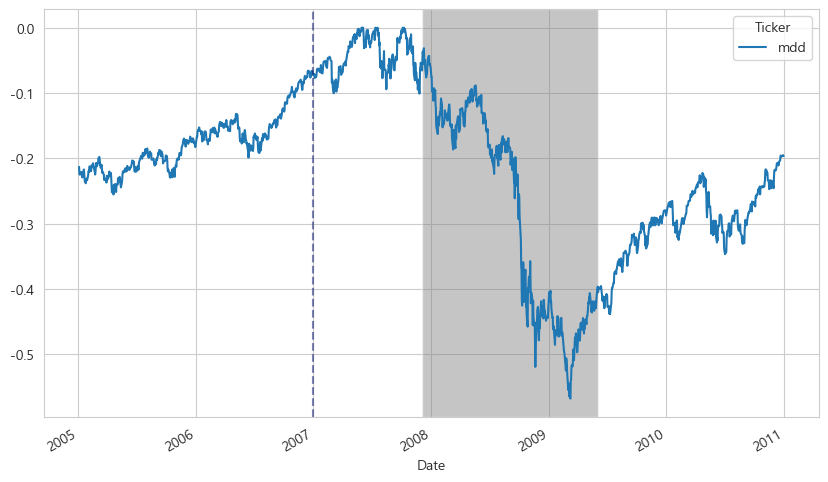

In [84]:
mdd_df[['mdd']]["2005":"2010"].plot()
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvline(x = '2007-01-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

In [85]:
mdd_df[['mdd']]["2005":"2010"].min()

Ticker
mdd   -0.567754
dtype: float64

### Now

In [94]:
df_sig_p4 = get_signals(dataset["2020-06-01":"2023-12-31"], ticker)
df_sig_p4 = df_sig_p4["2020-06-01":"2023-12-31"].copy()

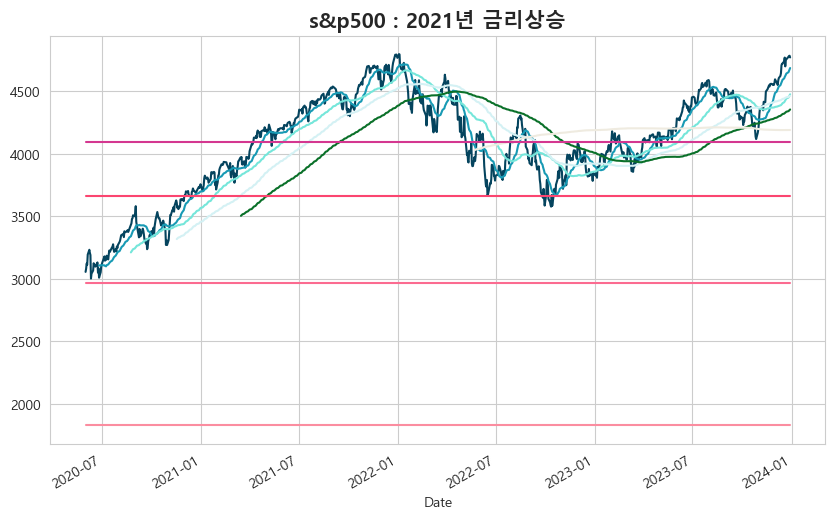

In [97]:
df_sig_p4.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#0A7029',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
plt.title("s&p500 : 2021년 금리상승", fontsize=15, fontweight='bold')  
## plt.yscale("log")
plt.show()

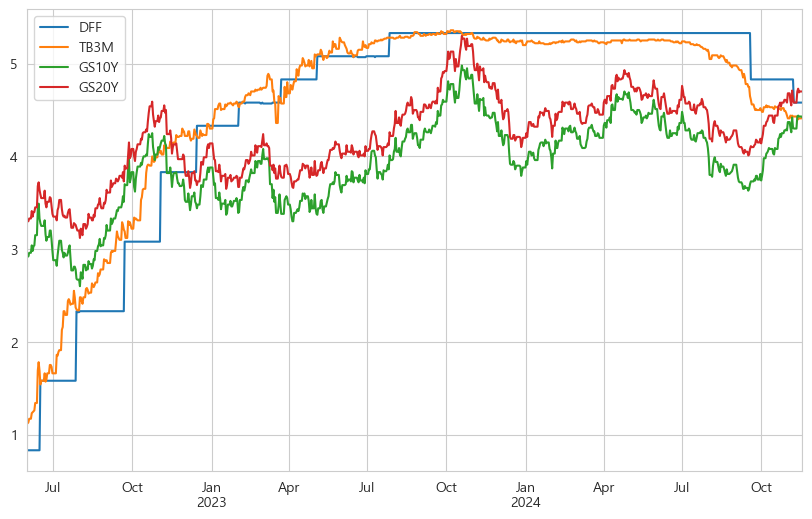

In [98]:
rate_df["2022-06-01":][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.show()

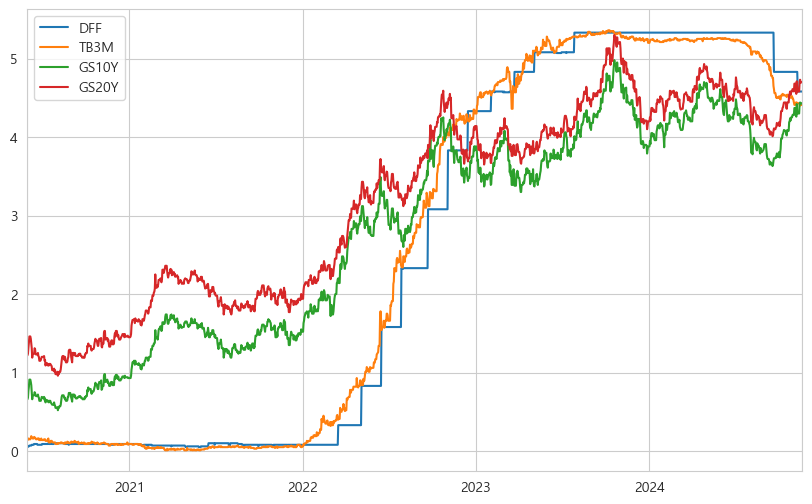

In [99]:
rate_df["2020-06-01":][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.show()

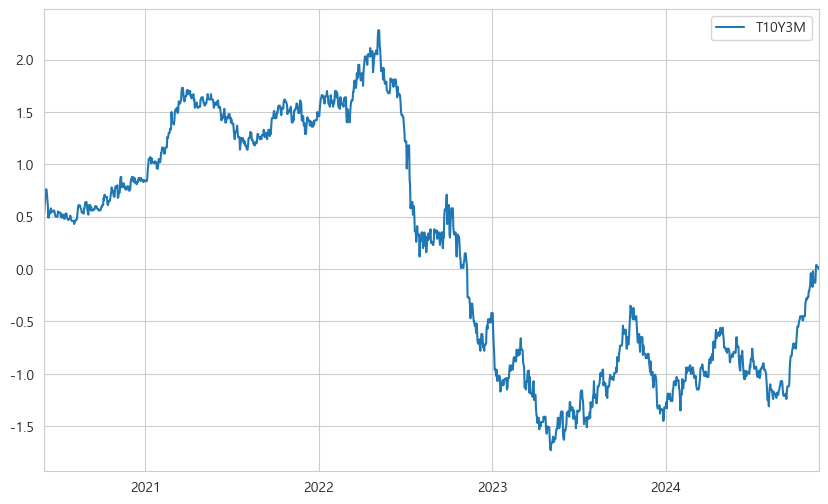

In [100]:
rate_data[['T10Y3M']]["2020-06-01":].plot()
plt.show()

In [104]:
17.30/88.57-1

-0.8046742689398216

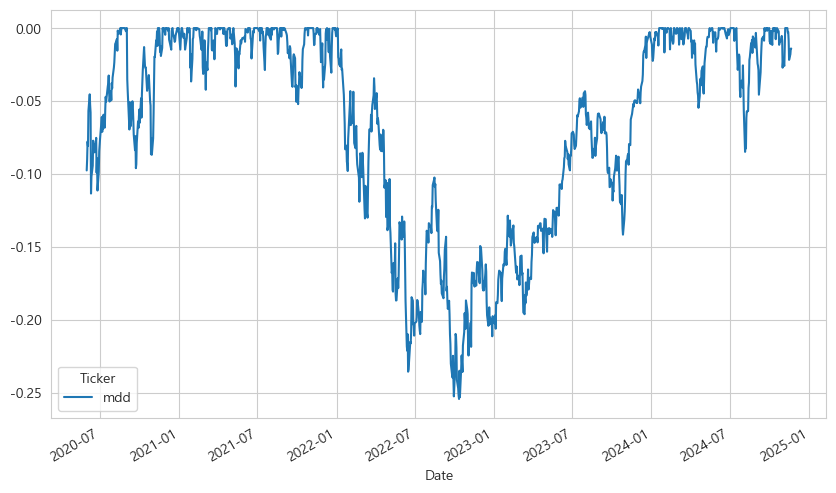

In [101]:
mdd_df[['mdd']]["2020-06-01":].plot()
plt.show()

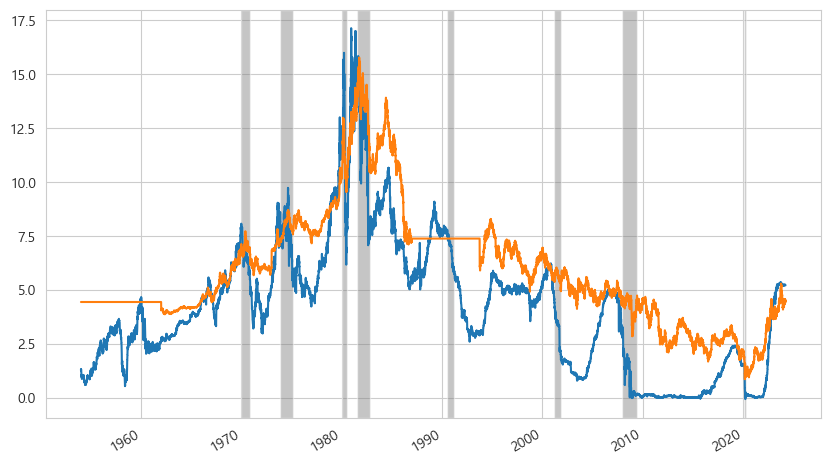

In [40]:
rate_data['TB3M'].plot()
rate_data['GS20Y'].plot()
plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)
plt.show()

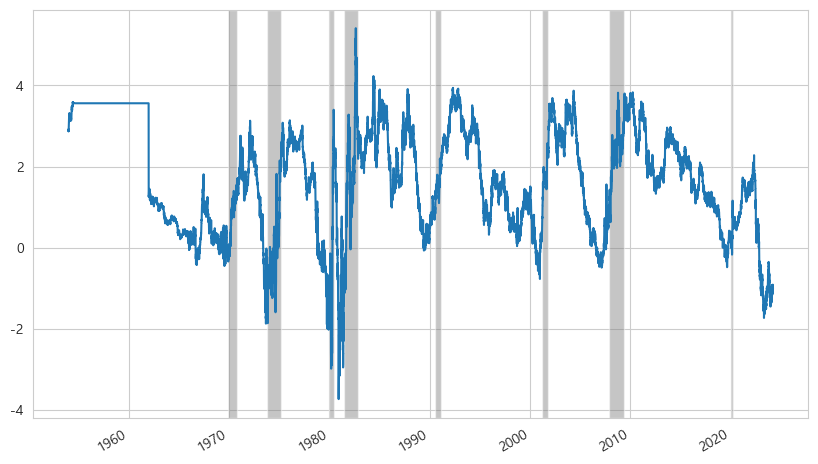

In [41]:
rate_data['T10Y3M'].plot()
plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)
plt.show()

<Axes: xlabel='Date'>

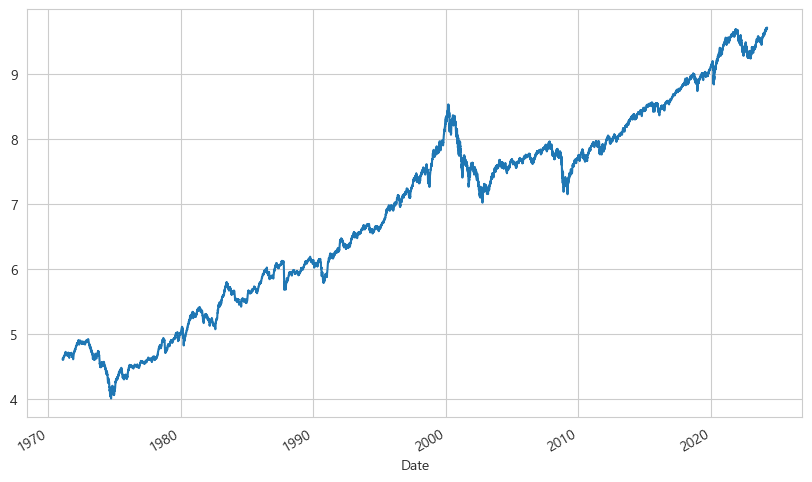

In [41]:
np.log(df['^IXIC'].dropna()).plot()

In [128]:
ticker = '^IXIC'

## 트리거 분석
hp_df = df[[ticker]].dropna().copy()
hp_df['hp'] = get_hp(hp_df[ticker])
hp_df["NYRR"] = hp_df[ticker].shift(-250)
hp_df["NYRR"] = hp_df["NYRR"]/hp_df[ticker] - 1
hp_df['mdd'] = hp_df[ticker]/hp_df['hp'] - 1

승률: 0.7376
평균 수익률: 0.1244


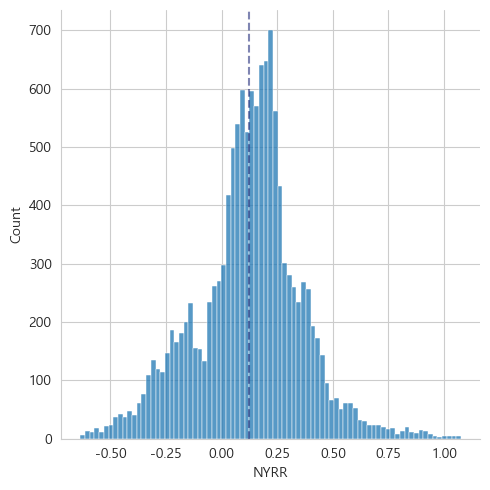

In [86]:
## 평균
sns.displot(hp_df['NYRR'])
plt.axvline(x = hp_df['NYRR'].mean(), color = '#000C66', linestyle = '--', alpha = 0.5)
print(f"승률: {(hp_df['NYRR'] >= 0).sum()/len(hp_df['NYRR']):.4f}")
print(f"평균 수익률: {hp_df['NYRR'].mean():.4f}")

승률: 0.6959
평균 수익률: 0.1089


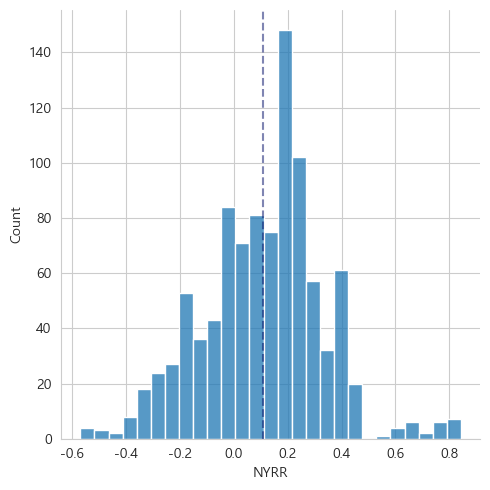

In [87]:
## 톨파시점
_temp = hp_df[hp_df[ticker] == hp_df['hp']]
sns.displot(_temp['NYRR'])
plt.axvline(x = _temp['NYRR'].mean(), color = '#000C66', linestyle = '--', alpha = 0.5)
print(f"승률: {(_temp['NYRR'] >= 0).sum()/len(_temp['NYRR']):.4f}")
print(f"평균 수익률: {_temp['NYRR'].mean():.4f}")

승률: 0.7562
평균 수익률: 0.1253


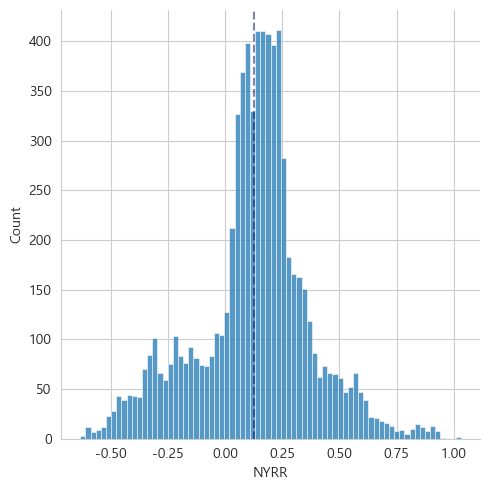

In [88]:
## mdd 10%
_temp = hp_df[hp_df['mdd'] < -0.1]
sns.displot(_temp['NYRR'])
plt.axvline(x = _temp['NYRR'].mean(), color = '#000C66', linestyle = '--', alpha = 0.5)
print(f"승률: {(_temp['NYRR'] >= 0).sum()/len(_temp['NYRR']):.4f}")
print(f"평균 수익률: {_temp['NYRR'].mean():.4f}")

승률: 0.7536
평균 수익률: 0.1064


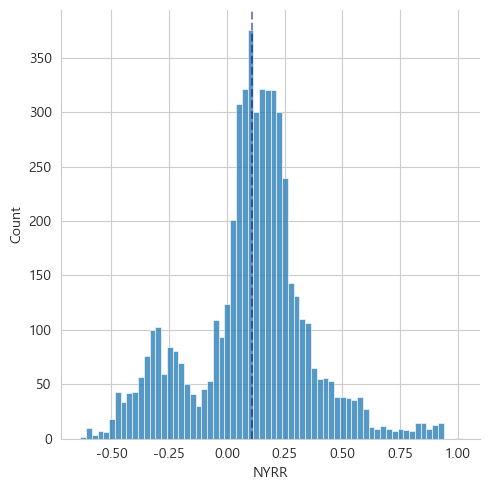

In [89]:
## mdd 10%
_temp = hp_df[hp_df['mdd'] < -0.2]
sns.displot(_temp['NYRR'])
plt.axvline(x = _temp['NYRR'].mean(), color = '#000C66', linestyle = '--', alpha = 0.5)
print(f"승률: {(_temp['NYRR'] >= 0).sum()/len(_temp['NYRR']):.4f}")
print(f"평균 수익률: {_temp['NYRR'].mean():.4f}")

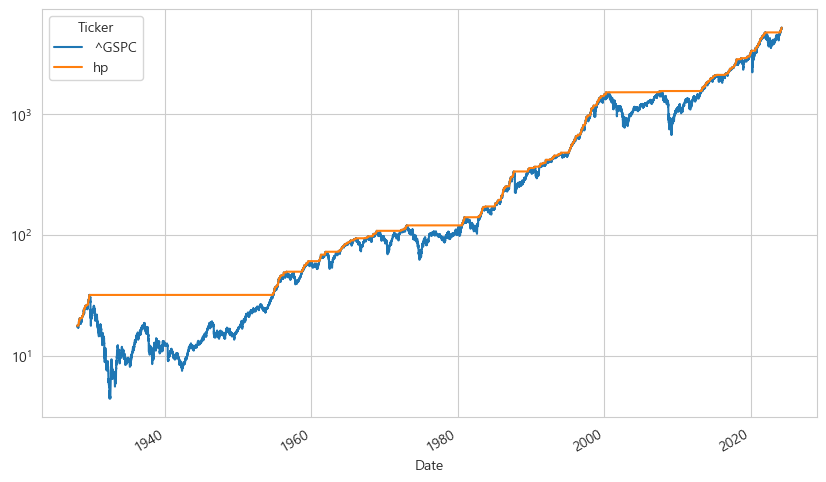

In [163]:
hp_df[[ticker, 'hp']].plot()
plt.yscale("log")

In [186]:
ticker = '^GSPC'

## 트리거 분석
hp_df = df[[ticker]].dropna().copy().tail(30000)
hp_df['hp'] = get_hp(hp_df[ticker])
hp_df["NYRR"] = hp_df[ticker].shift(-20*12)
hp_df["NYRR"] = hp_df["NYRR"]/hp_df[ticker] - 1
hp_df['mdd'] = hp_df[ticker]/hp_df['hp'] - 1


_ls = []
for i in range(0, 81):
    mdd = 0.01*i
    _temp = hp_df[hp_df['mdd'] < -mdd]
    _wr = (_temp['NYRR'] >= 0).sum()/len(_temp['NYRR'])
    _yrr = _temp['NYRR'].mean()
    _ls.append([mdd, _wr, _yrr])
    
result = pd.DataFrame(_ls)
result = result.dropna()
result.columns = ['MDD', 'WinRatio', 'YRR']
result = result[result['WinRatio']<1]

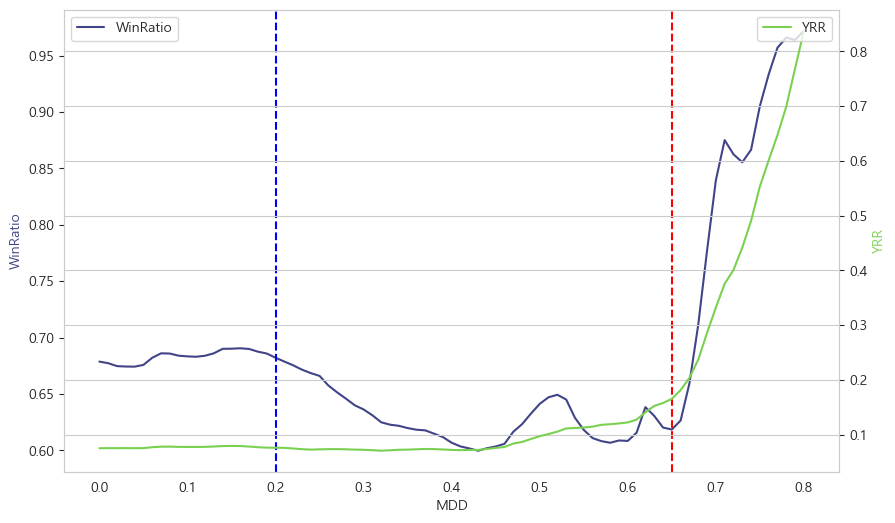

In [187]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Define colormap
cmap = plt.get_cmap('viridis')

# Plot WinRatio with smooth color
ax1.plot(result['MDD'], result['WinRatio'], color=cmap(0.2))
# Plot YRR with smooth color
ax2.plot(result['MDD'], result['YRR'], color=cmap(0.8))

ax1.set_xlabel('MDD')
ax1.set_ylabel('WinRatio', color=cmap(0.2))
ax2.set_ylabel('YRR', color=cmap(0.8))

ax1.grid(visible=False)  # Remove grid lines

ax1.legend(['WinRatio'], loc='upper left')
ax2.legend(['YRR'], loc='upper right')

# Find the index of the tipping point
n = 12
WinRatio_plus_tpoint_index = result['WinRatio'].pct_change(n).idxmax()-n
WinRatio_minus_tpoint_index = result['WinRatio'].pct_change(n).idxmin()-n
## YRR_tipping_point_index = result['YRR'].pct_change().idxmax()

# Draw a line perpendicular to the x-axis at the tipping point
ax1.axvline(x=result['MDD'][WinRatio_plus_tpoint_index], color='red', linestyle='--')
ax1.axvline(x=result['MDD'][WinRatio_minus_tpoint_index], color='blue', linestyle='--')
## ax2.axvline(x=result['MDD'][YRR_tipping_point_index-1], color='blue', linestyle='--')

plt.show()


In [262]:
def evaluate_portfolio(returns):
    """
    Evaluate the performance of a portfolio based on the returns.

    Parameters:
    returns (array-like): Array of portfolio returns.

    Returns:
    dict: Dictionary containing performance metrics.
    """
    metrics = {}

    # Calculate metrics
    metrics['Total Return'] = np.prod(1 + returns) - 1
    metrics['Annualized Return'] = (1 + metrics['Total Return']) ** ((1 / len(returns))*252) - 1 
    metrics['Annualized Volatility'] = np.std(returns) * np.sqrt(252)
    metrics['Sharpe Ratio'] = metrics['Annualized Return'] / metrics['Annualized Volatility']
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns / peak) - 1
    metrics['Max Drawdown'] = np.min(drawdown)
    metrics['Calmar Ratio'] = metrics['Annualized Return'] / abs(metrics['Max Drawdown'])
    metrics['Average Return'] = np.mean(returns)
    metrics['Median Return'] = np.median(returns)
    metrics['Win Percentage'] = (returns > 0).sum() / len(returns) * 100

    return pd.DataFrame(metrics, index=[0]).round(4)


In [266]:
ticker = '^IXIC'
## ticker = '^GSPC'
returns = df[ticker].pct_change().dropna()
evaluate_portfolio(returns)

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Average Return,Median Return,Win Percentage
0,162.7946,0.1006,0.2007,0.5012,-0.7793,0.1291,0.0005,0.0011,55.6509
